In [1]:
from datetime import datetime, timedelta
import json
import pathlib
from statistics import mean
from urllib import parse
import uuid

# See the companion document in Notion, especially on how to generate the HAR files:
#   - https://www.notion.so/athenianco/API-failure-rate-based-on-number-of-pods-and-number-of-parallel-users-20f7e99fcd89443698f44ff617f1cf69

HAR_FILES_PATH = 'REPLACE ME'

weights = {
  "/v1/filter/contributors": 2.5,
  "/v1/filter/repositories": 0.5,
  "/v1/filter/pull_requests": 6,
  "/v1/filter/commits": 1.5,
  "/v1/filter/releases": 1,
  "/v1/get/pull_requests": 0.5,
  "/v1/filter/labels": 0.5,
  "/v1/get/releases": 1,
  "/v1/diff/releases": 1,
  "/v1/filter/code_checks": 1,
  "/v1/match/identities": 1,
  "/v1/get/export": 4,
  "/v1/filter/jira": 2,
  "/v1/metrics/jira": 2.5,
  "/v1/histograms/jira": 1.5,
  "/v1/metrics/pull_requests": 10,
  "/v1/metrics/code_bypassing_prs": 1.5,
  "/v1/metrics/developers": 1.5,
  "/v1/metrics/releases": 4,
  "/v1/metrics/code_checks": 1,
  "/v1/metrics/deployments": 2,
  "/v1/histograms/pull_requests": 10,
  "/v1/histograms/code_checks": 1,
  "/v1/paginate/pull_requests": 1,
}

In [2]:
api_calls = {}
for path in pathlib.Path(HAR_FILES_PATH).glob('*.har'):
    with path.open() as fin:
         data = json.load(fin)

    filtered_entries = [
        d for d in data['log']['entries']
        if d['request']['method'] == 'POST' and
        d['request']['url'].startswith('https://api.athenian.co') and
        d['response']['status'] != 503        
    ]
    
    api_calls[path.name.rsplit(".")[0].replace(":", "/")] = [
        {
            'id': str(uuid.uuid4()),
            'path': parse.urlparse(entry['request']['url']).path,
            'start': datetime.strptime(entry['startedDateTime'], '%Y-%m-%dT%H:%M:%S.%f%z'),
            'duration': entry['time']
        }
        for entry in filtered_entries
    ]

def get_events_for_page(page):
    acs = api_calls[page]
    events = []
    for ac in acs:
        cost = weights[ac['path']]
        id_ = str(uuid.uuid4())
        events.extend([
            {
                'id': id_,
                'path': ac['path'],
                'timestamp': ac['start'],
                'cost': cost,
                'type': 'start',
            },
            {
                'id': id_,
                'path': ac['path'],
                'timestamp': ac['start'] + timedelta(milliseconds=ac['duration']),
                'cost': -cost,
                'type': 'end',
            },            
        ])

    events = sorted(events, key=lambda ev: ev['timestamp'])
    offset = events[0]['timestamp']
    cum_cost = 0
    for ev in events:
        ev['timestamp'] = (ev['timestamp'] - offset).total_seconds()
        cum_cost += ev['cost']
        ev['cum_cost'] = cum_cost
        
    return events

timelines = {page: get_events_for_page(page) for page in api_calls.keys()}

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools

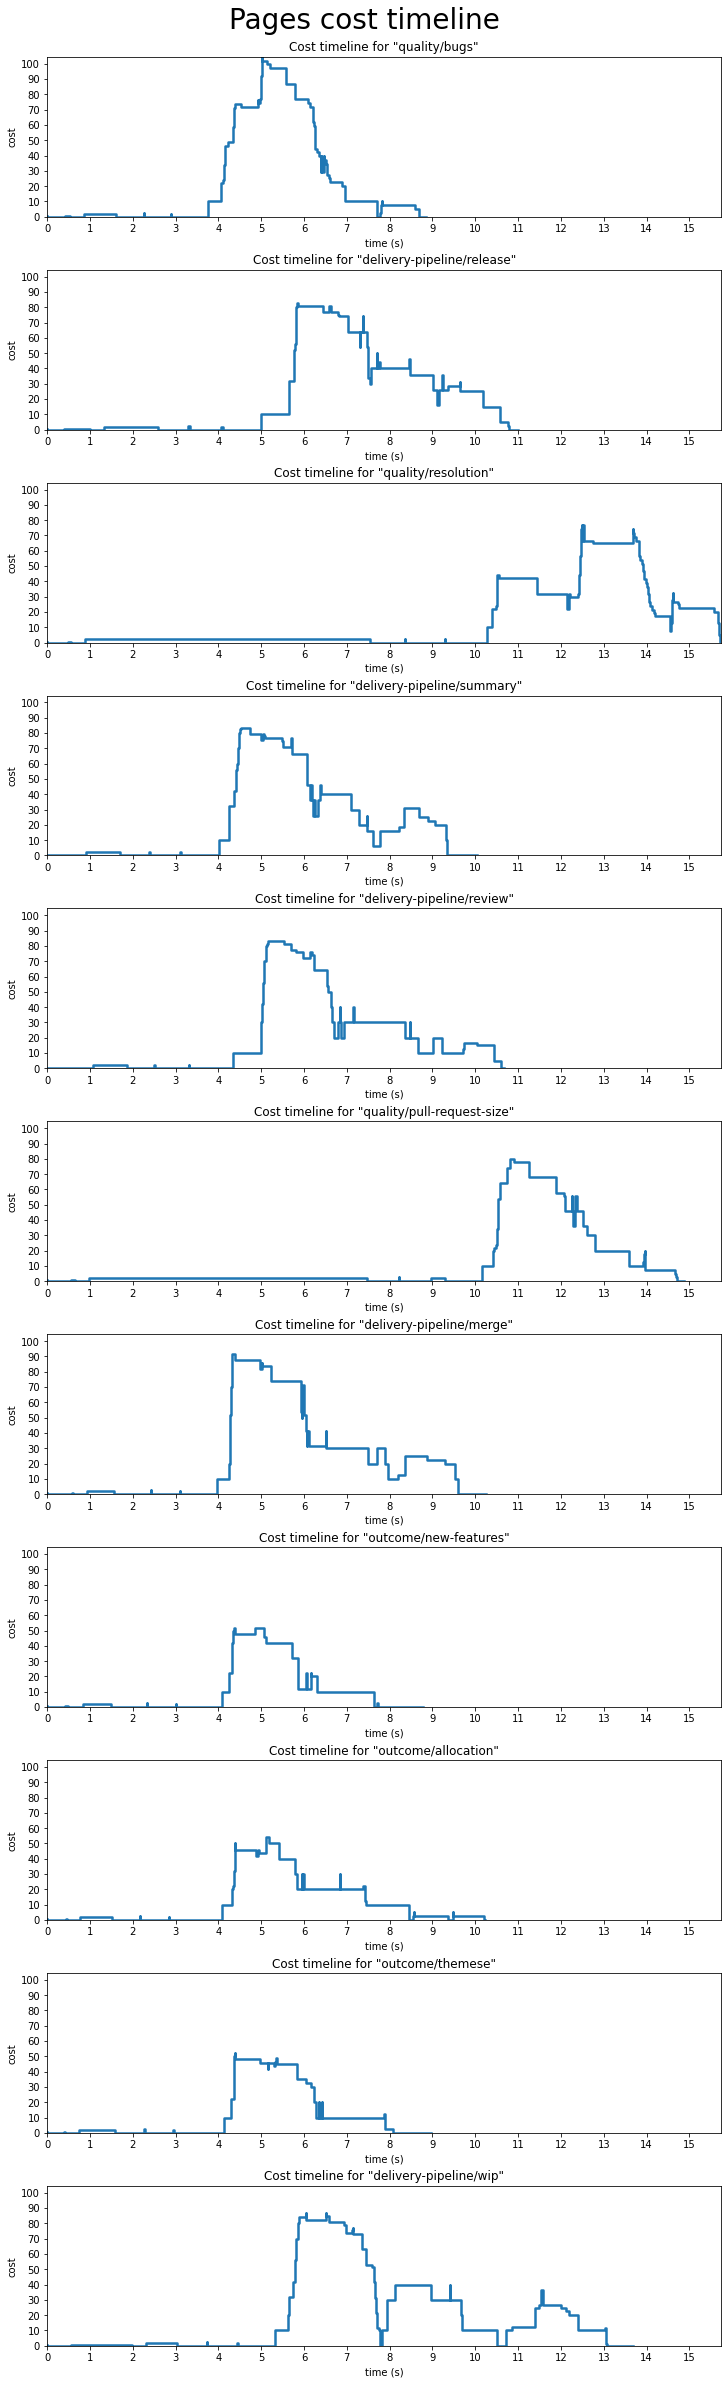

In [4]:
# Plotting
fig, axs = plt.subplots(len(timelines), 1, figsize=(10, 3 * len(timelines)), layout='constrained')
timelines_values = list(itertools.chain.from_iterable(timelines.values()))
max_x = max(tv['timestamp'] for tv in timelines_values)
max_y = max(tv['cum_cost'] for tv in timelines_values)
for i, (page, timeline) in enumerate(timelines.items()):
    ax = axs[i]
    ax.step([v['timestamp'] for v in timeline], [v['cum_cost'] for v in timeline], linewidth=2.5)
    ax.set(xlim=(0, max_x), xticks=np.arange(0, max_x),
           ylim=(0, max_y), yticks=np.arange(0, max_y, 10))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('cost')
    
    ax.set_title(f'Cost timeline for "{page}"')

fig.suptitle('Pages cost timeline', fontsize=28)
plt.show()

In [5]:
START_RANGE = [0, 10]
NUMBER_OF_USERS = 30
NUMBER_OF_PODS = 50
SINGLE_POD_QUOTA = 24
MAX_RETRIES = 5
DELAY = 1
SEED = 0

In [6]:
random.seed(SEED)
np.random.seed(SEED)

In [14]:
def build_user_sessions(number_of_users):
    starting_times = sorted([random.uniform(START_RANGE[0], START_RANGE[1]) for i in range(number_of_users)])
    sessions = {}
    for i, start in enumerate(starting_times):
        page = random.choice(list(api_calls.keys()))
        user = f'user-{i}'
        raw_timeline = get_events_for_page(page)
        timeline = [{ **rw, 'timestamp': rw['timestamp'] + start, 'user': user, 'page': page } for rw in raw_timeline]
        sessions[user] = {
            'start': start,
            'page': page,
            'timeline': timeline
        }
    
    return sessions

def build_grand_timeline(sessions):
    grand_timeline = sorted(itertools.chain.from_iterable([s['timeline'] for s in sessions.values()]),
                            key=lambda ev: ev['timestamp'])
    cum_cost = 0
    for ev in grand_timeline:
        cum_cost += ev['cost']
        ev['cum_cost'] = cum_cost
    
    return grand_timeline

def simulate(number_of_pods, number_of_users):
    sessions = build_user_sessions(number_of_users)
    grand_timeline = build_grand_timeline(sessions)
    
    pods = {i: 0 for i in range(number_of_pods)}
    pending_reqs = {}
    report = {f'user-{i}': {
        'errors': 0,
        'start': None,
        'end': None,
        'normal_time': (sessions[f'user-{i}']['timeline'][-1]['timestamp'] -
                        sessions[f'user-{i}']['timeline'][0]['timestamp']),
        'failed': False,
    } for i in range(number_of_users)}

    actual_events = []
    error_events = []
    while True:
        next_event = grand_timeline.pop(0)
        user = next_event['user']
        ev_type = next_event['type']
        ev_id = next_event['id']
        if ev_type == 'start':
            # New request start
            cost = next_event['cost']
            target_pod = random.choice(list(pods.keys()))
            current_pod_quota = pods[target_pod]
            if current_pod_quota + cost <= SINGLE_POD_QUOTA:
                # Target Pod can accept request
                pods[target_pod] += cost
                pending_reqs[ev_id] = {
                    'pod': target_pod,
                    'user': user,
                    'cost': cost
                }
                actual_events.append(next_event)
                if report[user]['start'] is None:
                    report[user]['start'] = next_event['timestamp']
            else:
                # Target Pod cannot accept request
                error_events.append({
                    'timestamp': next_event['timestamp']
                })
                report[user]['errors'] += 1
                pending_reqs[ev_id] = {
                    'user': user,
                    'failures': pending_reqs.get(ev_id, {}).get('failures', 0) + 1,
                    'cost': cost
                }
                if pending_reqs[ev_id]['failures'] >= MAX_RETRIES:
                    # Current request failed too many times, session failed
                    report[user]['failed'] = True
                    del pending_reqs[ev_id]
                    grand_timeline = [ev for ev in grand_timeline
                                      if (ev['user'] != user) or (ev['id'] in pending_reqs)]
                else:
                    # Current request failed, sleep for `DELAY`
                    grand_timeline.append(next_event)
                    for ev in grand_timeline:
                        if ev['user'] == user and ev['id'] not in pending_reqs:
                            ev['timestamp'] += DELAY

                    grand_timeline = sorted(grand_timeline, key=lambda ev: ev['timestamp'])
        else:
            # Request finish
            finished_req = pending_reqs[ev_id]
            pods[finished_req['pod']] -= finished_req['cost']
            report[user]['end'] = next_event['timestamp']
            del pending_reqs[ev_id]
            actual_events.append(next_event)

        if len(grand_timeline) == 0:
            break

    cum_cost = 0
    for ev in actual_events:
        cum_cost += ev['cost']
        ev['cum_cost'] = cum_cost
        
    return report, actual_events, error_events

def plot_timeline(report, events, error_events, n_users, n_pods):
    values = {
        'x': [v['timestamp'] for v in events],
        'y': [v['cum_cost'] for v in events]
    }
    fig, ax = plt.subplots(figsize=(10, 4), layout='constrained')
    max_quota = SINGLE_POD_QUOTA * n_pods
    failures = sum(r['failed'] for r in report.values())
    
    ax.plot([0, max(values['x'])], [max_quota] * 2, 'r-', linewidth=2.5)

    for er_ev in error_events:
        ax.plot([er_ev['timestamp']] * 2, [0, max_quota * 1.1], 'm--', linewidth=1)

    ax.step(values['x'], values['y'], linewidth=2.5)
    max_x = max(values['x'])
    max_y = max(max(values['y']), max_quota) * 1.1
    ax.set(xlim=(0, max_x), xticks=np.arange(0, max_x),
           ylim=(0, max_y), yticks=np.arange(0, max_y, 100))
    ax.set_xlabel('time (s)')
    ax.set_ylabel('cost')
    ax.set_title(f'Cost timeline (users={n_users}, pods={n_pods}, errors={len(error_events)}, failures={failures})')
    
    return fig

In [8]:
MAX_NUMBER_PODS = 100
PODS_STEP = 5
MAX_NUMBER_USERS = 100
USERS_STEP = 5

agg_data = {}
for n_pods in range(PODS_STEP, MAX_NUMBER_PODS + PODS_STEP, PODS_STEP):
    for n_users in range(USERS_STEP, MAX_NUMBER_USERS + USERS_STEP, USERS_STEP):
        print(f"Simulating: pods={n_pods} user={n_users}")
        report, actual_events, error_events = simulate(n_pods, n_users)
        agg_data[(n_pods, n_users)] = {
            "report": report,
            "actual_events": actual_events,
            "error_events": error_events
        }

Simulating: pods=5 user=5
Simulating: pods=5 user=10
Simulating: pods=5 user=15
Simulating: pods=5 user=20
Simulating: pods=5 user=25
Simulating: pods=5 user=30
Simulating: pods=5 user=35
Simulating: pods=5 user=40
Simulating: pods=5 user=45
Simulating: pods=5 user=50
Simulating: pods=5 user=55
Simulating: pods=5 user=60
Simulating: pods=5 user=65
Simulating: pods=5 user=70
Simulating: pods=5 user=75
Simulating: pods=5 user=80
Simulating: pods=5 user=85
Simulating: pods=5 user=90
Simulating: pods=5 user=95
Simulating: pods=5 user=100
Simulating: pods=10 user=5
Simulating: pods=10 user=10
Simulating: pods=10 user=15
Simulating: pods=10 user=20
Simulating: pods=10 user=25
Simulating: pods=10 user=30
Simulating: pods=10 user=35
Simulating: pods=10 user=40
Simulating: pods=10 user=45
Simulating: pods=10 user=50
Simulating: pods=10 user=55
Simulating: pods=10 user=60
Simulating: pods=10 user=65
Simulating: pods=10 user=70
Simulating: pods=10 user=75
Simulating: pods=10 user=80
Simulating: p

Simulating: pods=75 user=80
Simulating: pods=75 user=85
Simulating: pods=75 user=90
Simulating: pods=75 user=95
Simulating: pods=75 user=100
Simulating: pods=80 user=5
Simulating: pods=80 user=10
Simulating: pods=80 user=15
Simulating: pods=80 user=20
Simulating: pods=80 user=25
Simulating: pods=80 user=30
Simulating: pods=80 user=35
Simulating: pods=80 user=40
Simulating: pods=80 user=45
Simulating: pods=80 user=50
Simulating: pods=80 user=55
Simulating: pods=80 user=60
Simulating: pods=80 user=65
Simulating: pods=80 user=70
Simulating: pods=80 user=75
Simulating: pods=80 user=80
Simulating: pods=80 user=85
Simulating: pods=80 user=90
Simulating: pods=80 user=95
Simulating: pods=80 user=100
Simulating: pods=85 user=5
Simulating: pods=85 user=10
Simulating: pods=85 user=15
Simulating: pods=85 user=20
Simulating: pods=85 user=25
Simulating: pods=85 user=30
Simulating: pods=85 user=35
Simulating: pods=85 user=40
Simulating: pods=85 user=45
Simulating: pods=85 user=50
Simulating: pods=85 

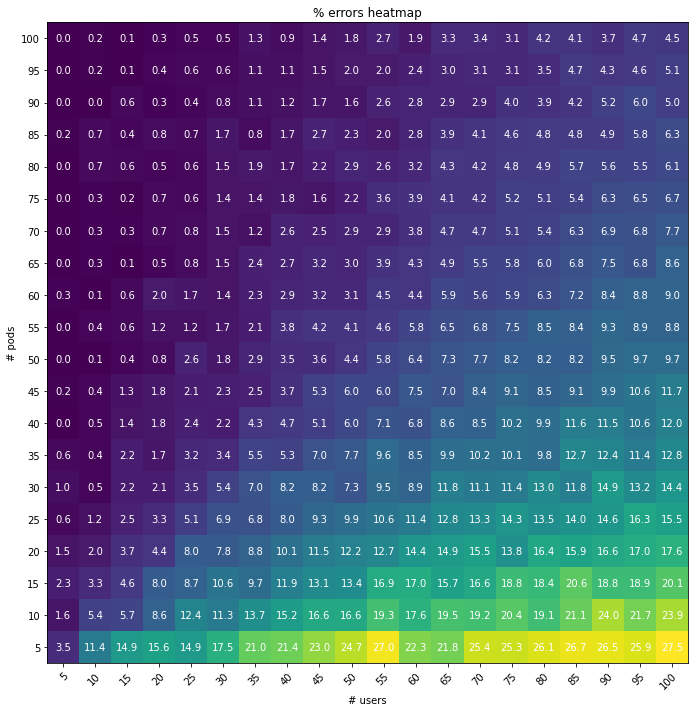

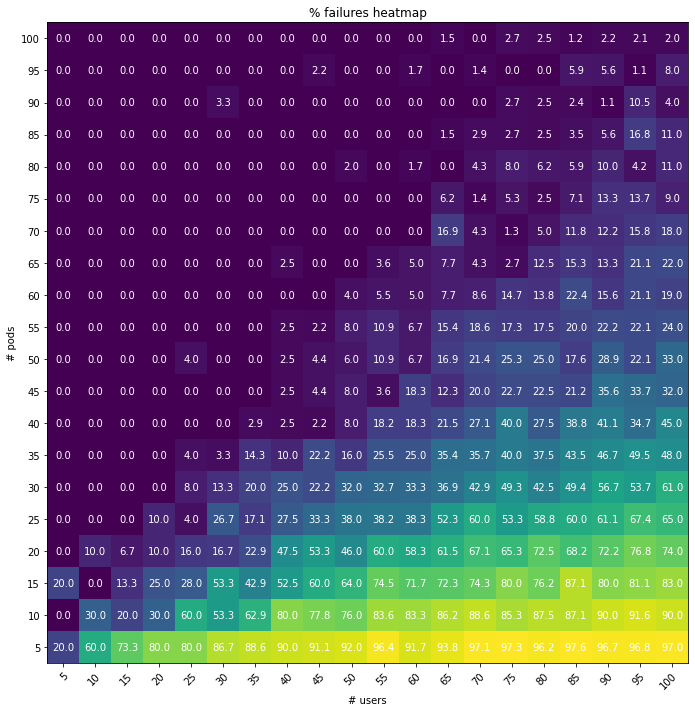

In [23]:
def plot_heatmap(title, value_calculator, dtype):
    users_axis = list(range(USERS_STEP, MAX_NUMBER_USERS + USERS_STEP, USERS_STEP))
    pods_axis = list(range(PODS_STEP, MAX_NUMBER_PODS + PODS_STEP, PODS_STEP))[::-1]

    values = np.zeros((len(users_axis), len(pods_axis)), dtype=dtype)
    for j, n_pods in enumerate(pods_axis):
        for i, n_users in enumerate(users_axis):
            data = agg_data[(n_pods, n_users)]
            values[j][i] = value_calculator(data, n_pods, n_users)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(values)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(users_axis)), labels=users_axis)
    ax.set_yticks(np.arange(len(pods_axis)), labels=pods_axis)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(users_axis)):
        for j in range(len(pods_axis)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center", color="w")

    ax.set_xlabel('# users')
    ax.set_ylabel('# pods')
    ax.set_title(title)
    fig.tight_layout()
    return fig

f1 = plot_heatmap('% errors heatmap',
                  lambda data, n_pods, n_users: round(
                      len(data['error_events']) / len(data['actual_events']) / 2 * 100, 1),
                  float
                 )
f2 = plot_heatmap('% failures heatmap',
                  lambda data, n_pods, n_users: round(
                      sum(r['failed'] for r in data['report'].values()) / n_users * 100, 1),
                  float
                 )

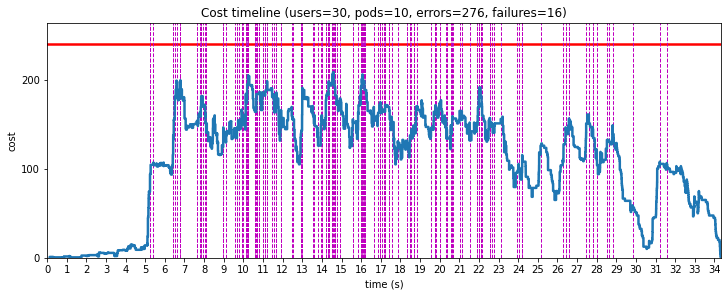

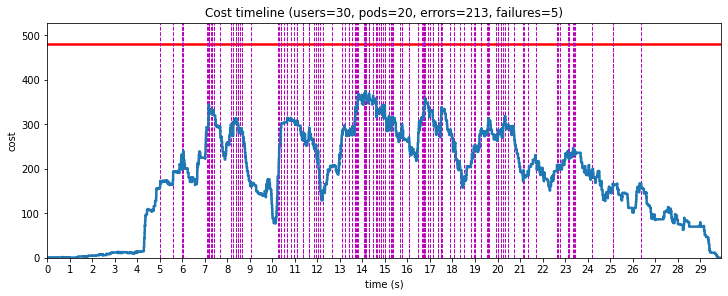

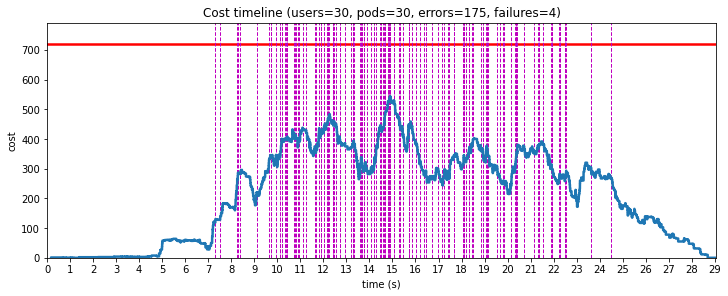

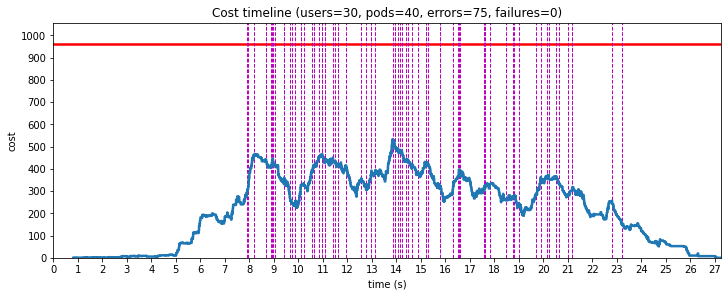

In [26]:
number_of_users = 30
for number_of_pods in range(10, 45, 10):
    sample_data = agg_data[(number_of_pods, number_of_users)]
    fig = plot_timeline(sample_data['report'], sample_data['actual_events'], sample_data['error_events'], number_of_users, number_of_pods)